#### Introduction
This script aims to predict Bitcoin prices based on historical price data using machine learning models. It involves data preprocessing, feature engineering, model training, and evaluation. By leveraging models like Linear Regression, Random Forest, and LSTM, we aim to analyze price trends and make informed predictions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('bitcoin.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
df.shape

(2713, 7)

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


#### Exploratory Data Analysis

Before moving further, let’s check for the null values if any are present in the data frame.

While performing the EDA of the Bitcoin Price data we will analyze how prices of the cryptocurrency have moved over the period of time and how the end of the quarters affects the prices of the currency.

In [12]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

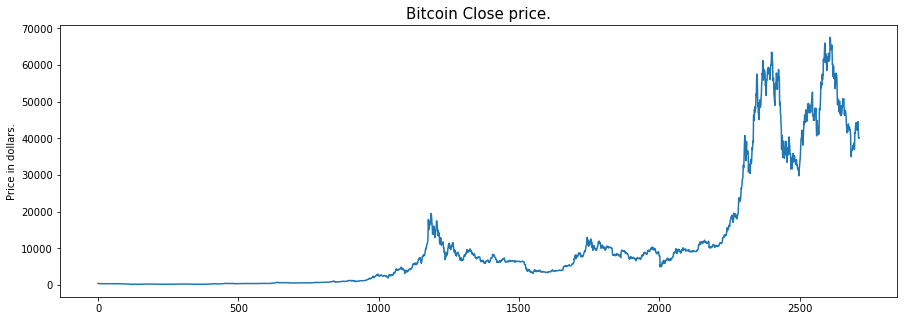

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.title('Bitcoin Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

The prices of the Bitcoin stocks are showing an upward trend as depicted by the plot of the closing price of the stocks.

In [9]:
df[df['Close'] == df['Adj Close']].shape, df.shape

((2713, 7), (2713, 7))

From here we can conclude that all the rows of columns ‘Close’ and ‘Adj Close’ have the same data. So, having redundant data in the dataset is not going to help so, we’ll drop this column before further analysis.

In [10]:
df = df.drop(['Adj Close'], axis=1)

Now let’s draw the distribution plot for the continuous features given in the dataset.

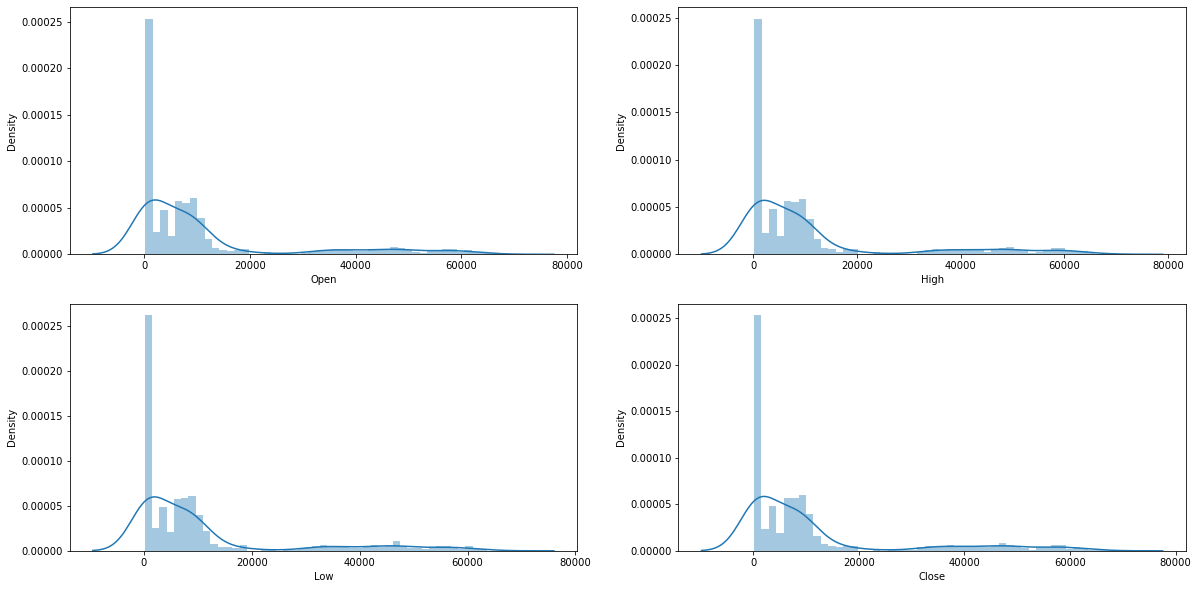

In [13]:
features = ['Open', 'High', 'Low', 'Close']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.distplot(df[col])
plt.show()

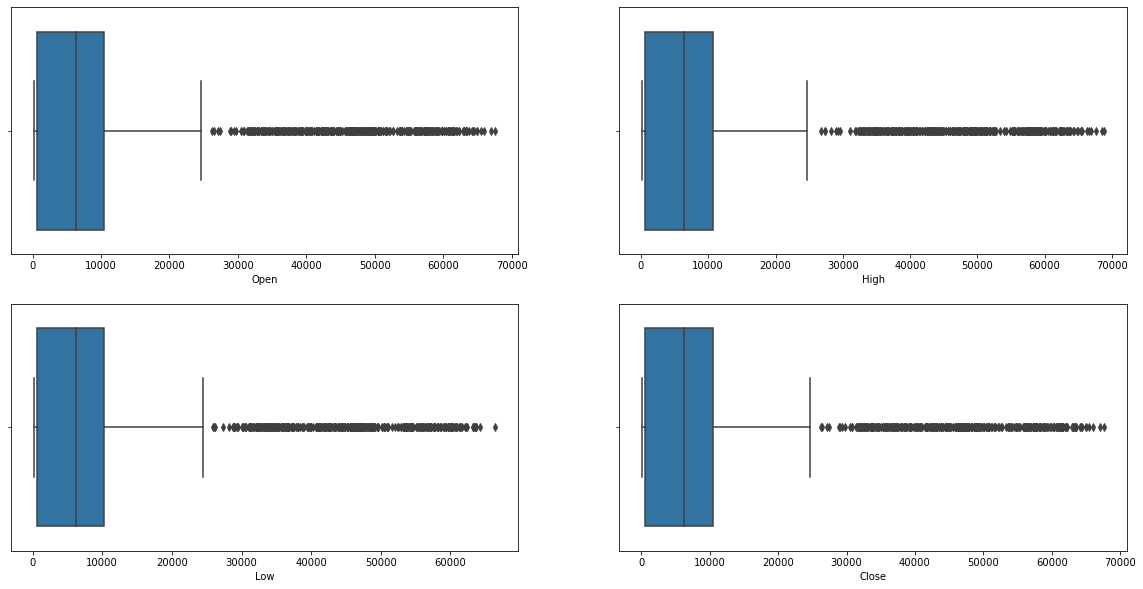

In [14]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.boxplot(df[col])
plt.show()

There are so many outliers in the data which means that the prices of the stock have varied hugely in a very short period of time. Let’s check this with the help of a barplot. 

#### Feature Engineering
Feature Engineering helps to derive some valuable features from the existing ones. These extra features sometimes help in increasing the performance of the model significantly and certainly help to gain deeper insights into the data.

In [15]:
splitted = df['Date'].str.split('-', expand=True)

df['year'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int')
df['day'] = splitted[2].astype('int')

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date']) 

df.head()


,Date,Open,High,Low,Close,Volume,year,month,day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


Now we have three more columns namely ‘day’, ‘month’ and ‘year’ all these three have been derived from the ‘Date’ column which was initially provided in the data.

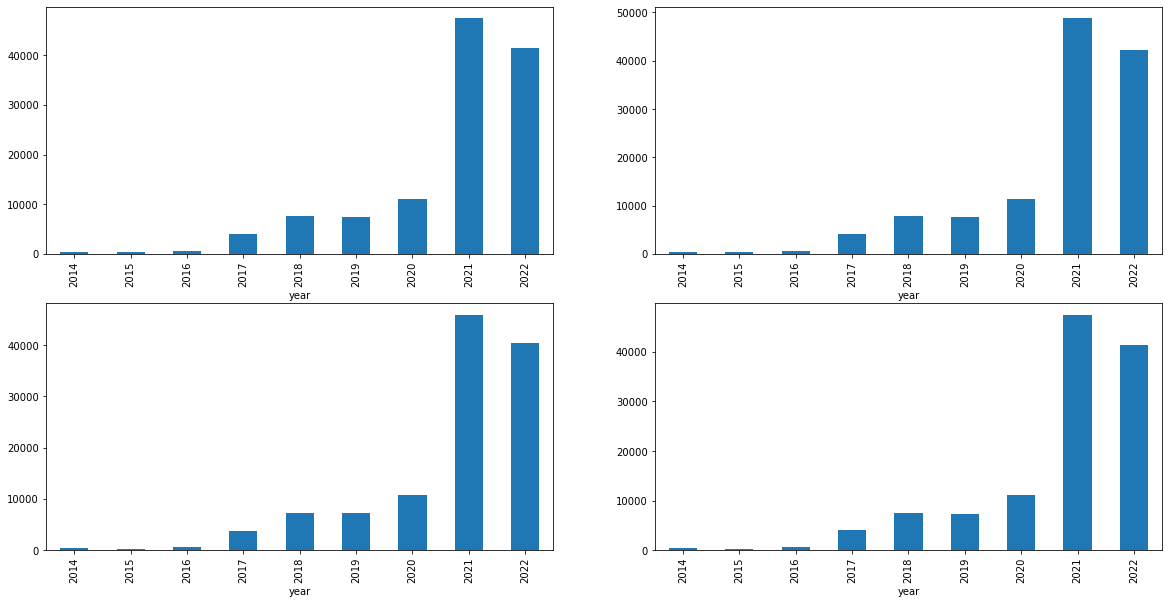

In [16]:
data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [19]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,open-close,low-high,target,is_quarter_end
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,8.529999,-15.752014,0,1
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,32.419983,-43.755981,0,1
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,29.307007,-43.302978,1,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,-14.230988,-33.412994,0,1
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,9.263977,-19.244995,1,1


Here we can observe why there are so many outliers in the data as the prices of bitcoin have exploded in the year 2021.

In [20]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

Above we have added some more columns which will help in the training of our model. We have added the target feature which is a signal whether to buy or not we will train our model to predict this only. But before proceeding let’s check whether the target is balanced or not using a pie chart.

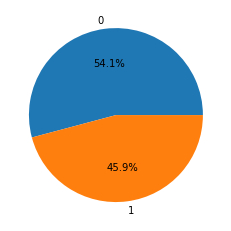

In [21]:
plt.pie(df['target'].value_counts().values, 
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

When we add features to our dataset we have to ensure that there are no highly correlated features as they do not help in the learning process of the algorithm.

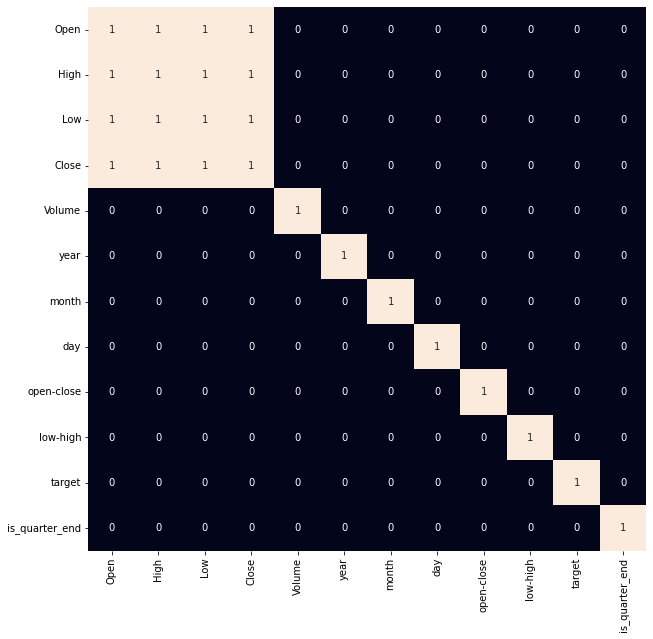

In [22]:
plt.figure(figsize=(10, 10))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

From the above heatmap, we can say that there is a high correlation between OHLC which is pretty obvious, and the added features are not highly correlated with each other or previously provided features which means that we are good to go and build our model.

In [23]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
#We do not use train test split, rather use the first 70% data to train and last 30% to test
X_train, X_valid, Y_train, Y_valid = X_train, X_valid, Y_train, Y_valid = features[:len(features)//7],features[len(features)//7:],target[:len(features)//7],target[len(features)//7:]

After selecting the features to train the model on we should normalize the data because normalized data leads to stable and fast training of the model. After that whole data has been split into two parts with a 90/10 ratio so, that we can evaluate the performance of our model on unseen data.

#### Model Development and Evaluation

Now is the time to train some state-of-the-art machine learning models(Logistic Regression, Support Vector Machine, XGBClassifier), and then based on their performance on the training and validation data we will choose which ML model is serving the purpose at hand better.

For the evaluation metric, we will use the ROC-AUC curve but why this is because instead of predicting the hard probability that is 0 or 1 we would like it to predict soft probabilities that are continuous values between 0 to 1. And with soft probabilities, the ROC-AUC curve is generally used to measure the accuracy of the predictions.

In [25]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5350328683662017
Validation Accuracy :  0.5171419395315489

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.4620811287477955
Validation Accuracy :  0.4875466808078394

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training 

Among the three models, we have trained XGBClassifier has the highest performance but it is pruned to overfitting as the difference between the training and the validation accuracy is too high. But in the case of the Logistic Regression, this is not the case.

Now let’s plot a confusion matrix for the validation data.

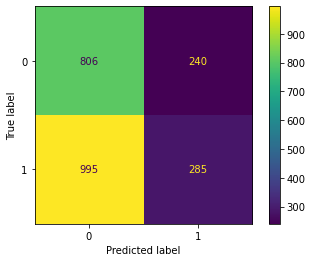

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)
plt.show()

#### Conclusion:
The Bitcoin price prediction model provides insights into future price movements using historical data. While machine learning models like LSTM capture long-term trends, traditional models offer stable predictions. Future work can enhance predictions by incorporating external macroeconomic factors and sentiment analysis.
We can observe that the accuracy achieved by the state-of-the-art ML model is no better than simply guessing with a probability of 50%. Possible reasons for this may be the lack of data or using a very simple model to perform such a complex task as Stock Market prediction.
